# <font color='firebrick'><center>Report for Bam Stats</center></font>
### This report details the bamstats output tables that have been generated as part of running bamstats tool.
<br>



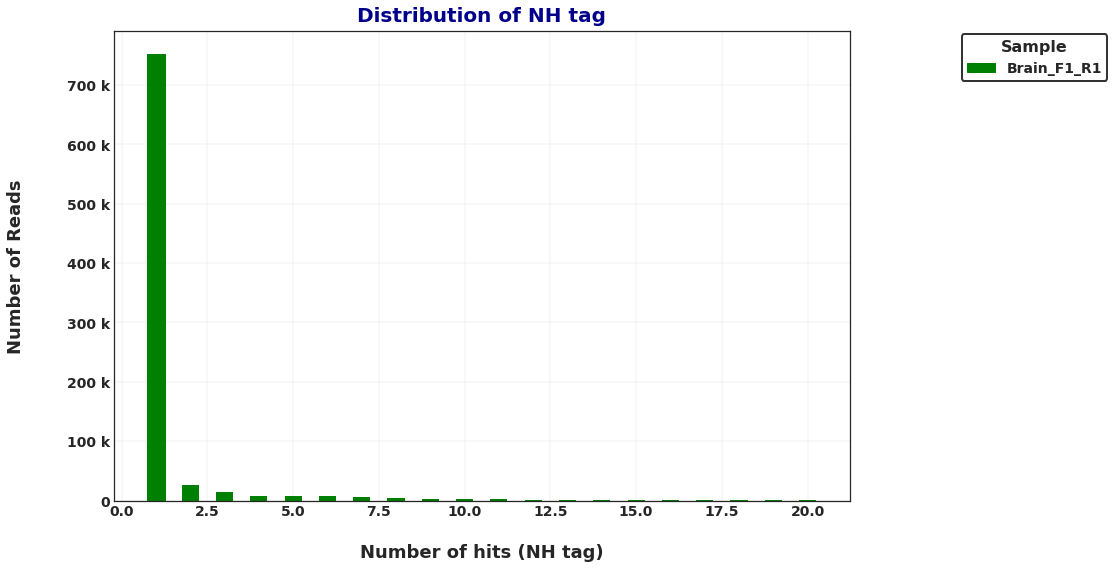

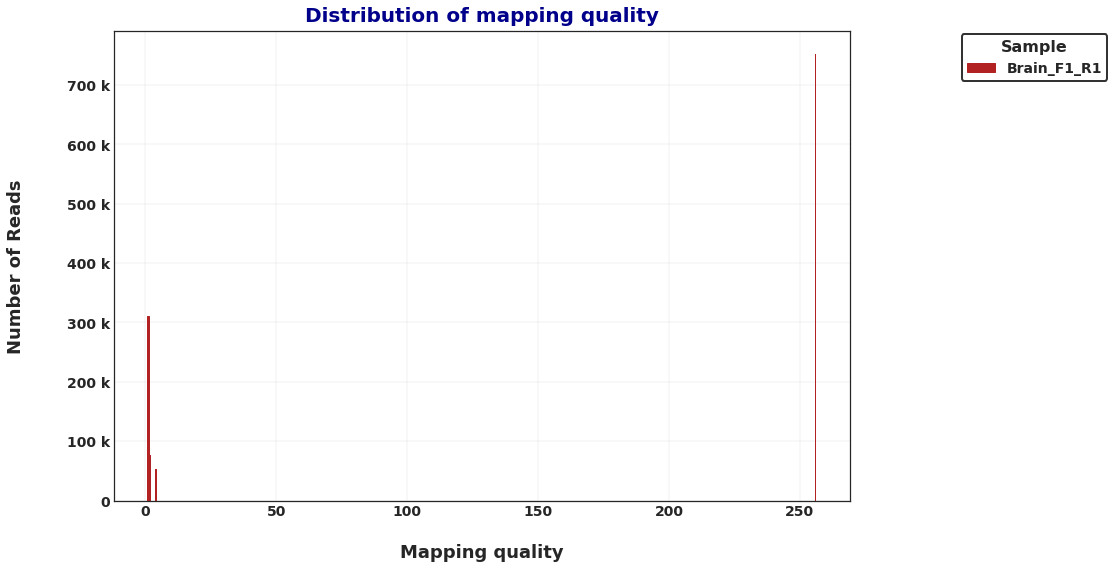

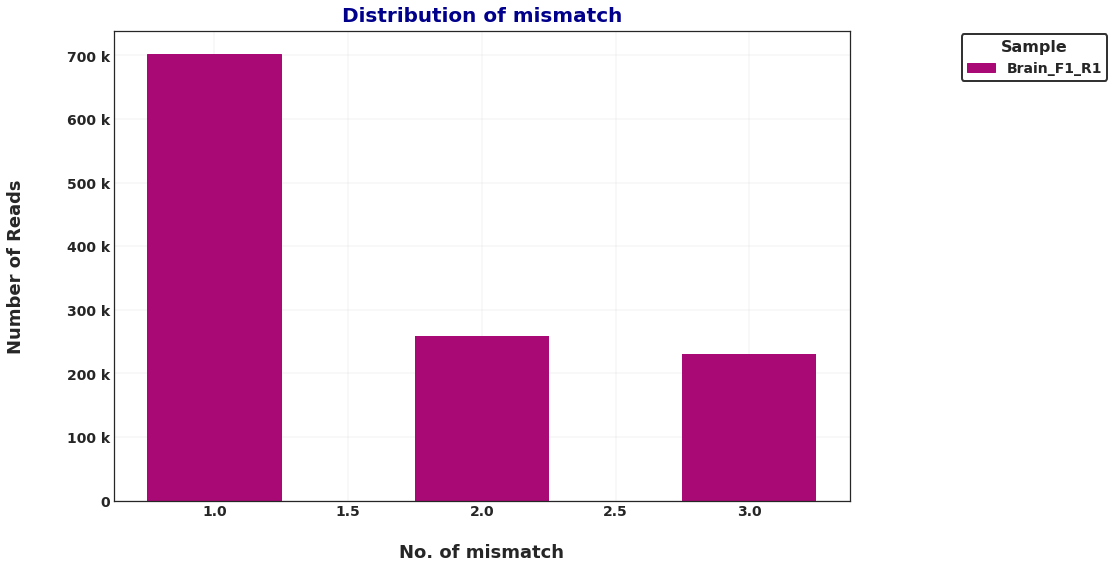

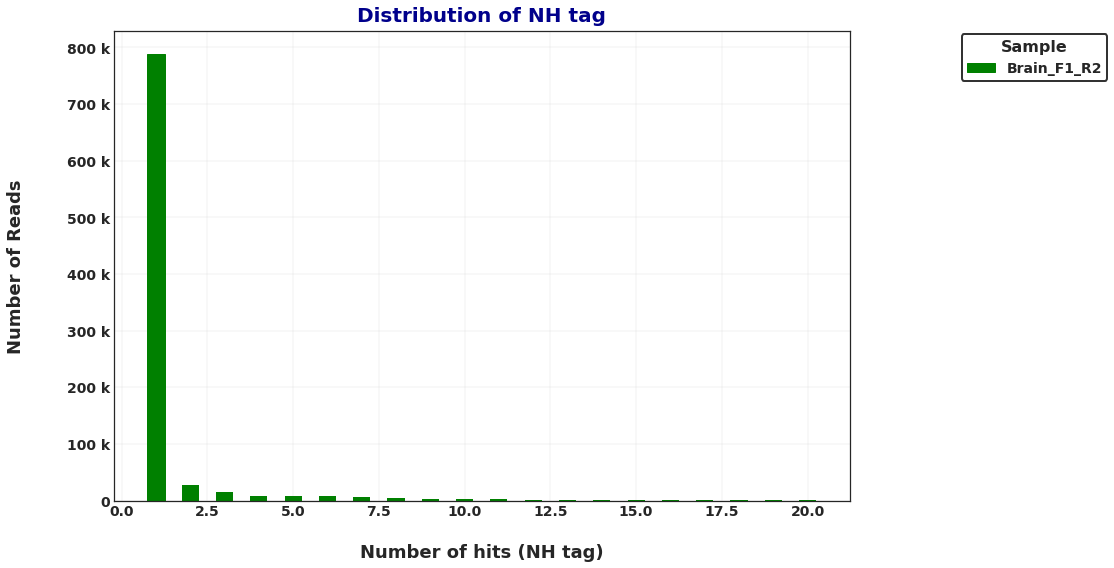

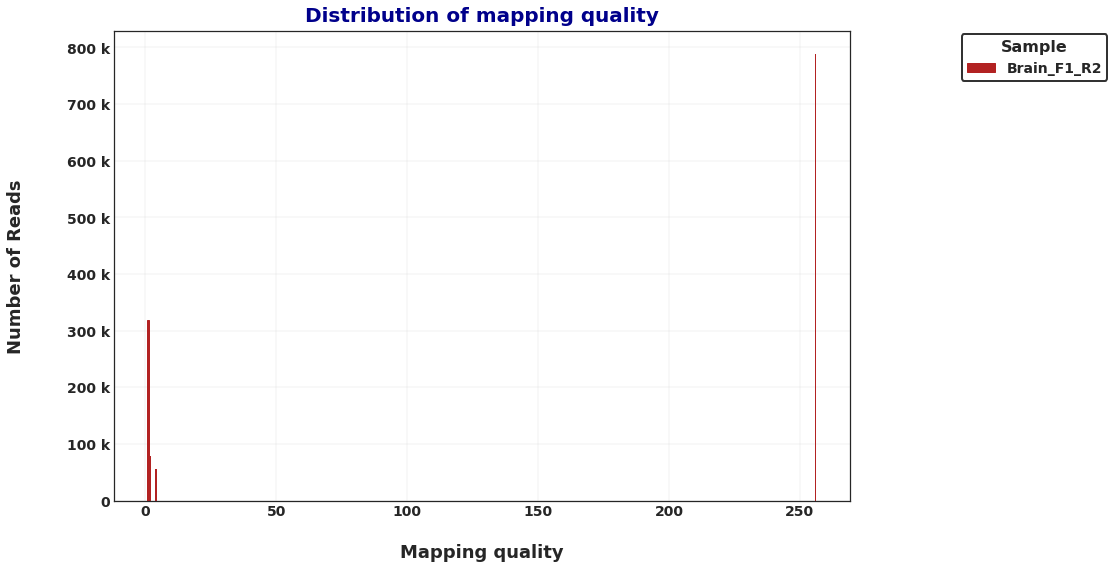

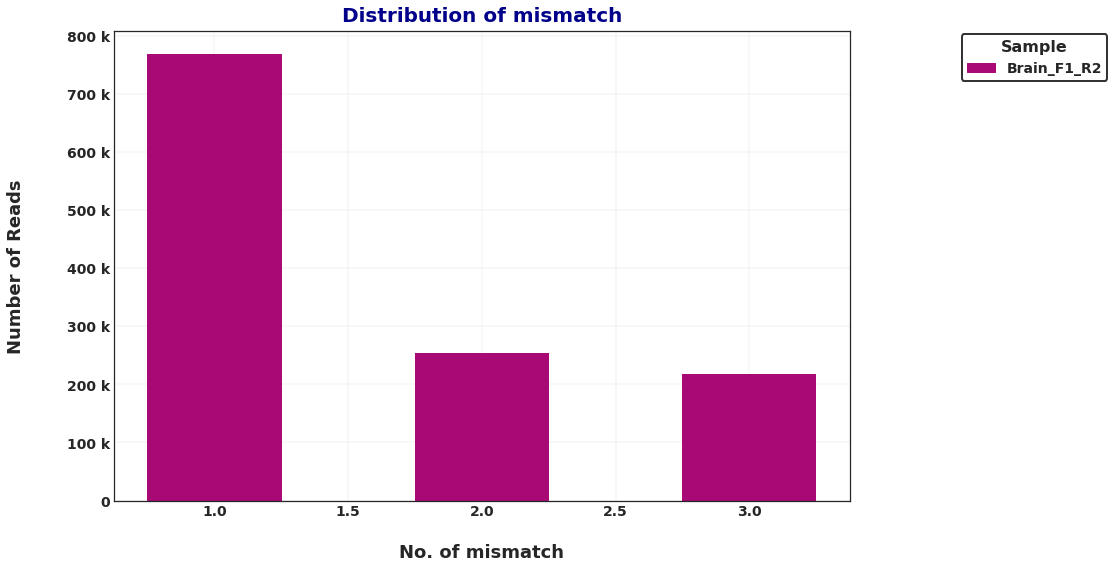

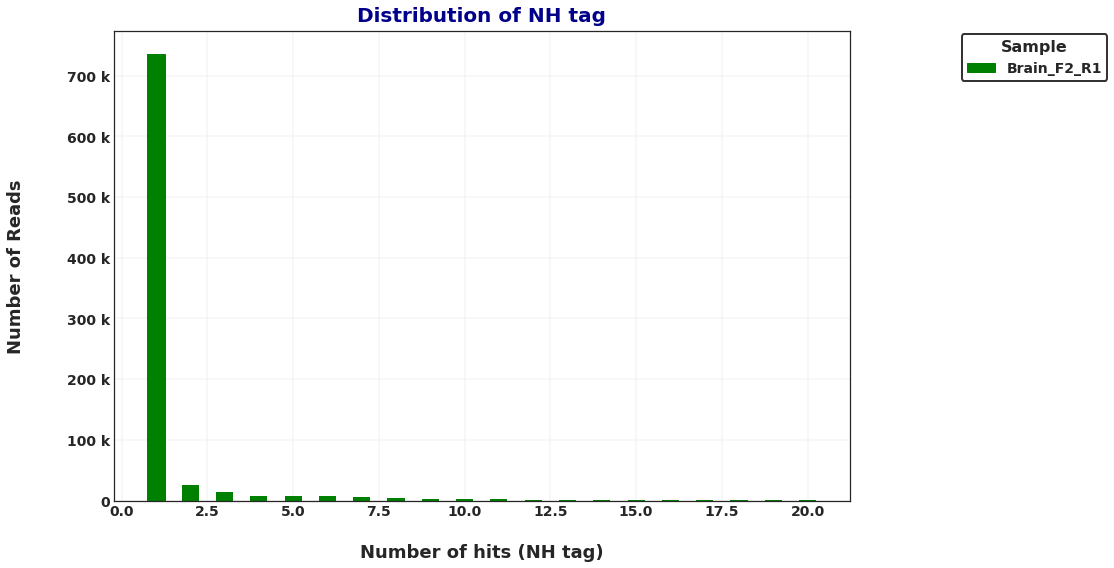

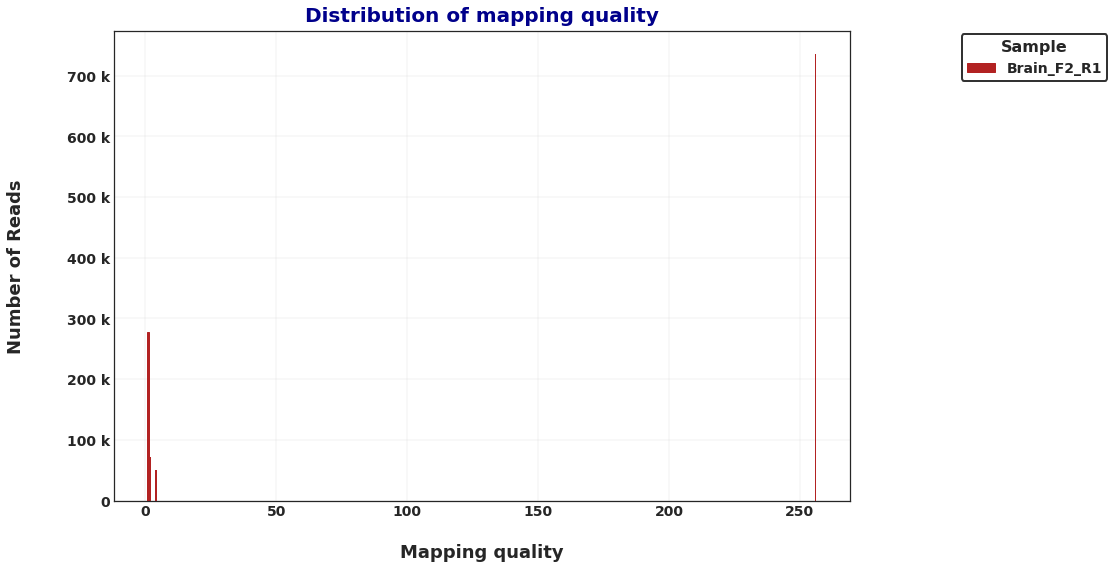

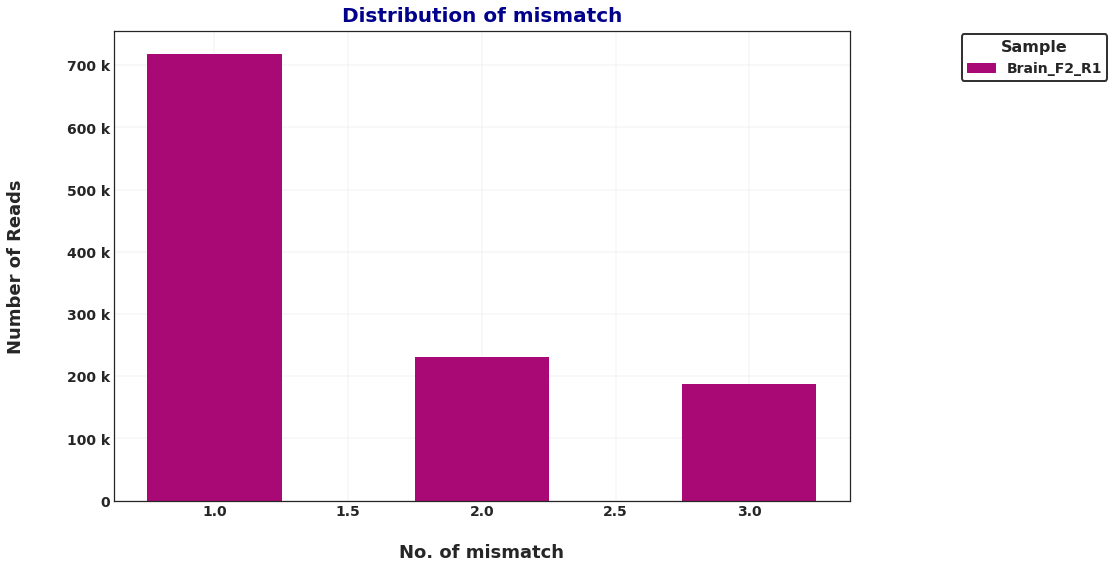

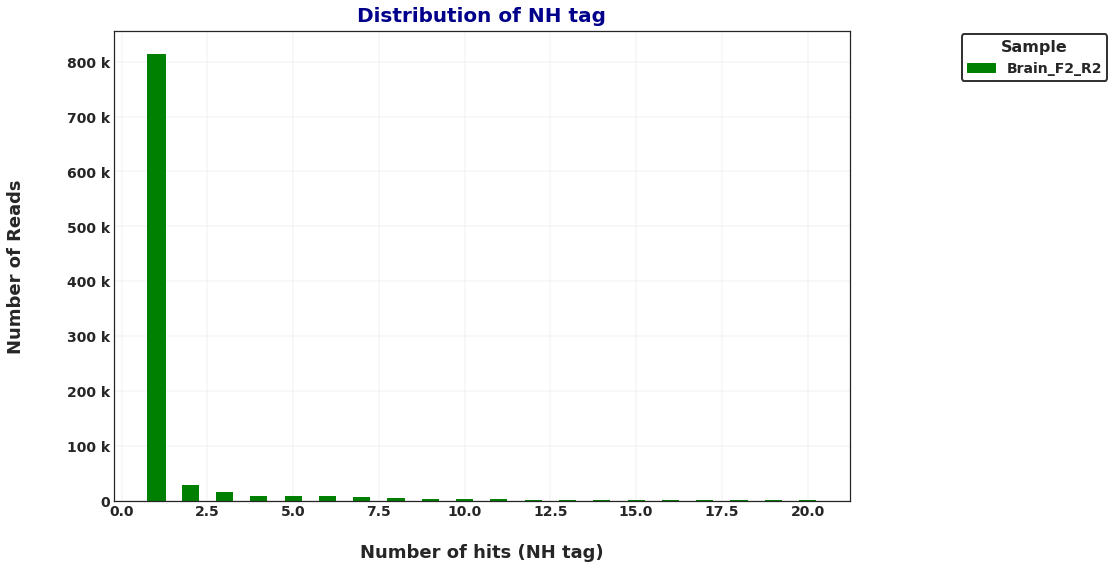

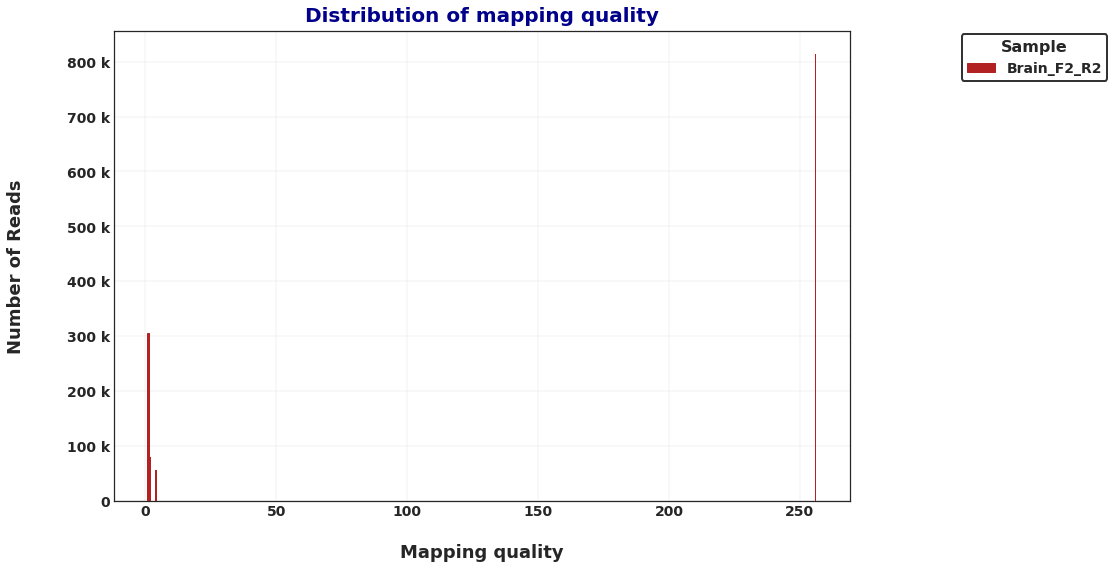

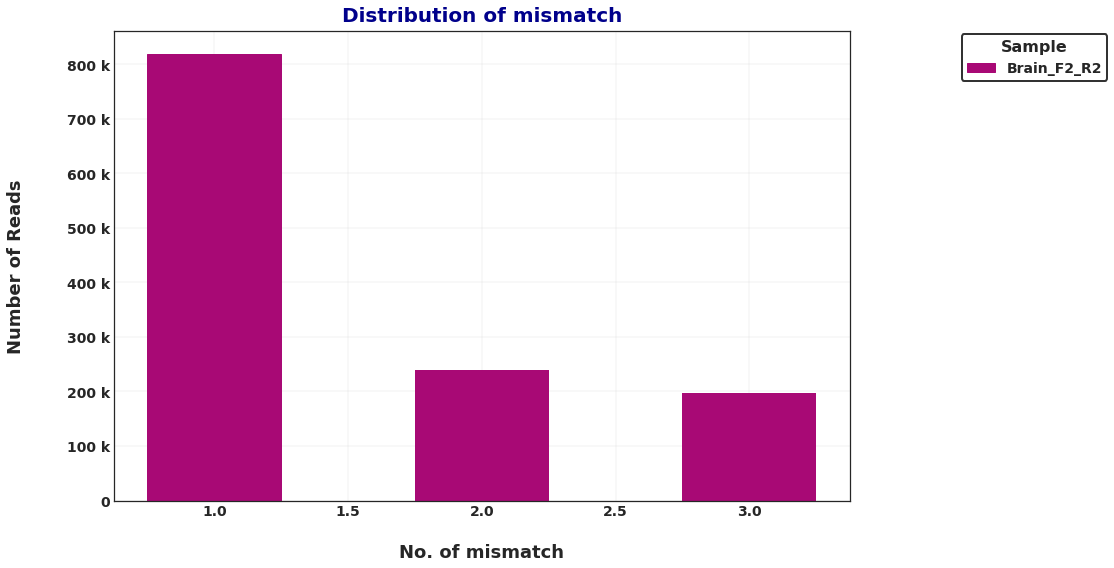

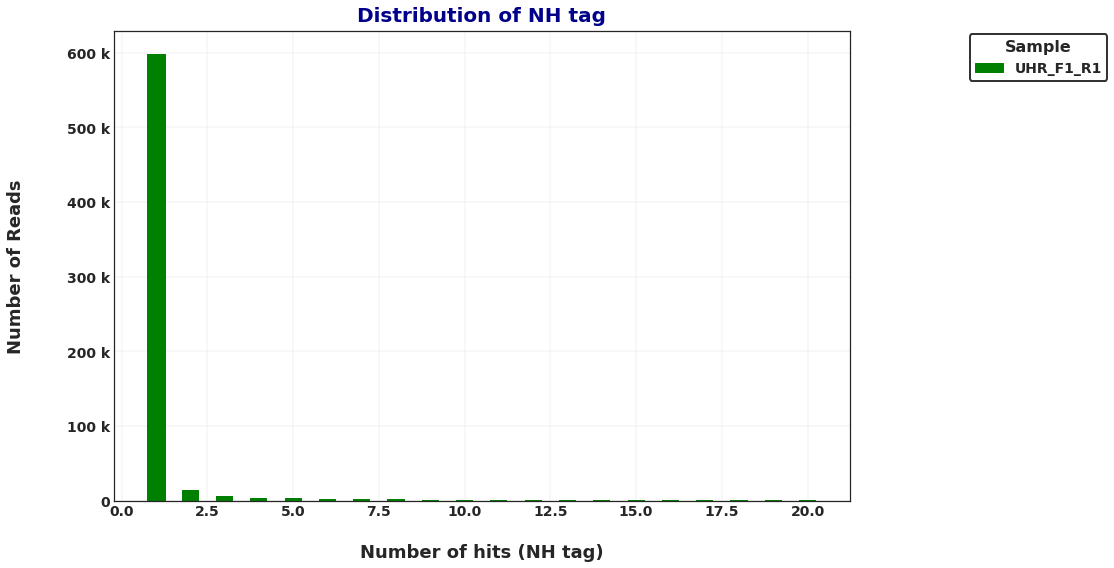

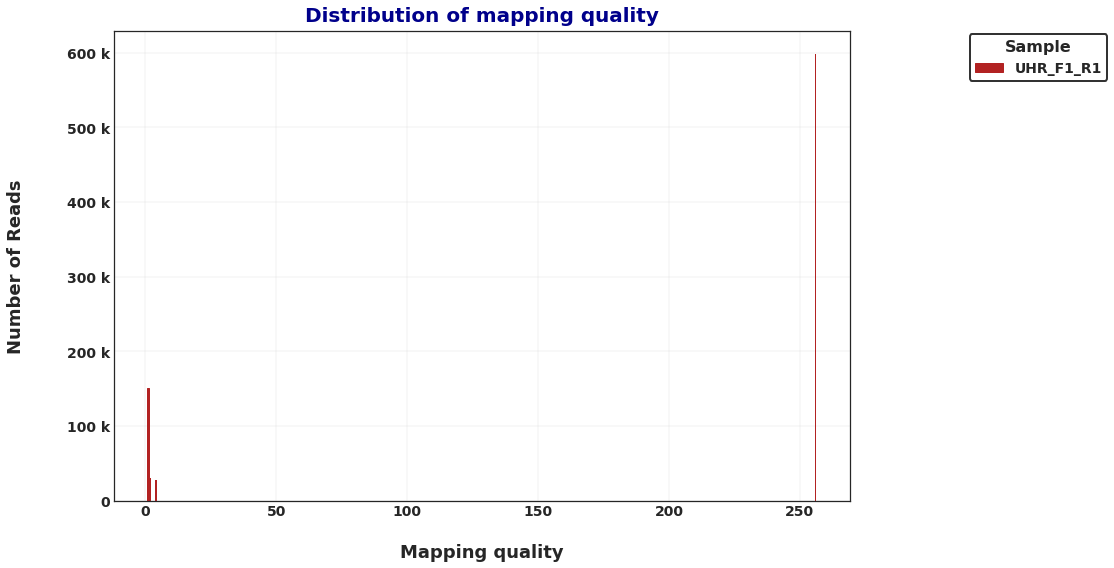

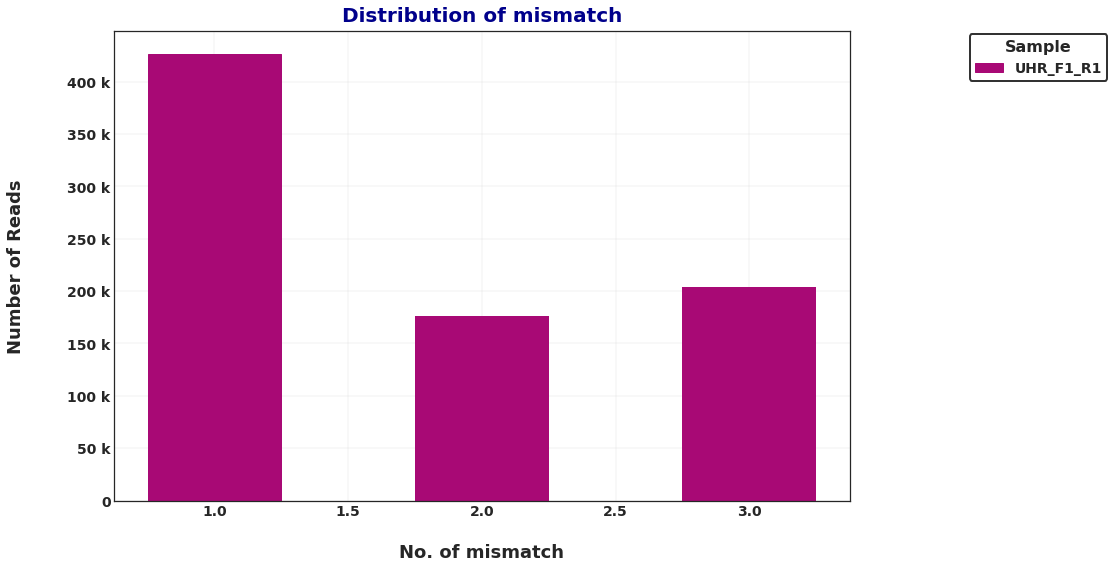

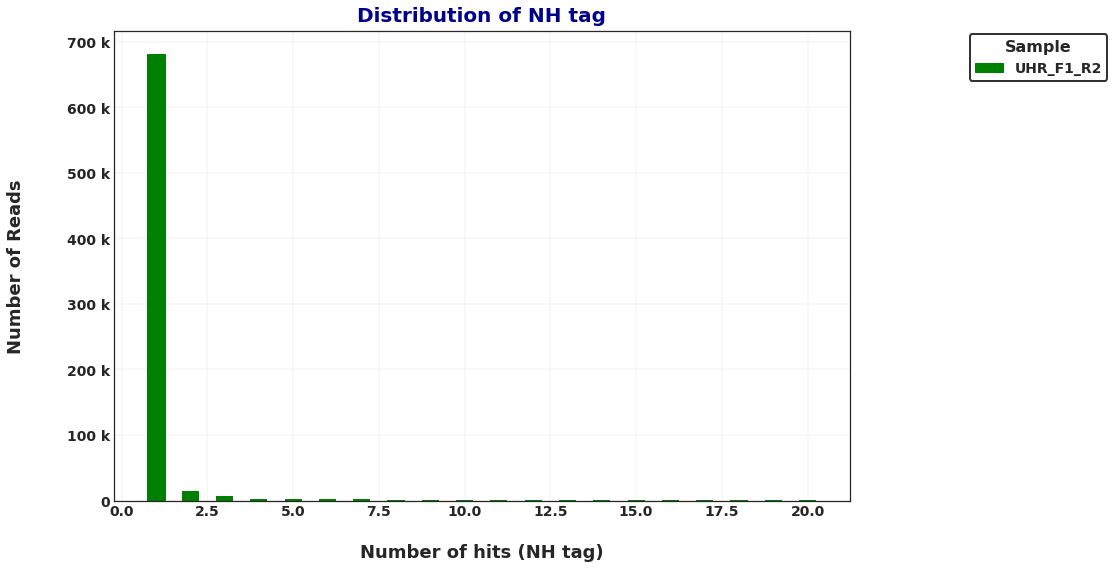

In [ ]:
from IPython.display import display, Markdown
from IPython.display import HTML
import IPython.core.display as di
import csv
import numpy as np
import zlib
import CGAT.IOTools as IOTools
import itertools as ITL
import os
import string
import pandas as pd
import sqlite3
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages  # noqa: E402
#mpl.use('Agg')  # noqa: E402
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as font_manager
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import rc, font_manager
import CGAT.Experiment as E
import math
from random import shuffle
import matplotlib as mpl
import datetime
import seaborn as sns
import nbformat
%matplotlib inline  


##################################################
#Plot customization
#plt.ioff()
plt.style.use('seaborn-white')
#plt.style.use('ggplot')
title_font = {'size':'20','color':'darkblue', 'weight':'bold', 'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size':'18', 'weight':'bold'}
#For summary page pdf
'''To add description page
plt.figure() 
plt.axis('off')
plt.text(0.5,0.5,"my title",ha='center',va='center')
pdf.savefig()
'''
#Panda data frame cutomization
pd.options.display.width = 80
pd.set_option('display.max_colwidth', -1)

feature = ['input','mapped','spliced','unspliced']
colors_category = ['yellowgreen', 'pink', 'gold', 'lightskyblue', 
              'orchid','darkgoldenrod','skyblue','b', 'red', 
              'darkorange','grey','violet','magenta','cyan',
              'hotpink','mediumslateblue']
threshold = 5

def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])

def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    #print(val, signf)
                    if str(val).split(".")[1] == "0":
                       return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

def getTables(dbname):
    '''
    Retrieves the names of all tables in the database.
    Groups tables into dictionaries by annotation
    '''
    dbh = sqlite3.connect(dbname)
    c = dbh.cursor()
    statement = "SELECT name FROM sqlite_master WHERE type='table'"
    c.execute(statement)
    tables = c.fetchall()
    print(tables)
    c.close()
    dbh.close()
    return 

def readDBTable(dbname, tablename):
    '''
    Reads the specified table from the specified database.
    Returns a list of tuples representing each row
    '''
    dbh = sqlite3.connect(dbname)
    c = dbh.cursor()
    statement = "SELECT * FROM %s" % tablename
    c.execute(statement)
    allresults = c.fetchall()
    c.close()
    dbh.close()
    return allresults

def getDBColumnNames(dbname, tablename):
    dbh = sqlite3.connect(dbname)
    res = pd.read_sql('SELECT * FROM %s' % tablename, dbh)
    dbh.close()
    return res.columns

def plotBamstats(df,i_index,name,track_name,colors,xname,titlename):   
        fig,ax = plt.subplots()
        ax.grid(which='major', linestyle='-', linewidth='0.25')
        ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
        index=list(range(1,len(df.loc[track_name])+1))
        plt.bar(index,df.loc[df.index[i_index]],0.50,color=colors,label=df.index[i_index],edgecolor=colors)
        fig = plt.gcf()
        fig.set_size_inches(12,8)
        plt.xticks(fontsize = 14,weight='bold')
        plt.yticks(fontsize = 14,weight='bold')
        legend_properties = {'weight':'bold','size':'14'}
        leg = plt.legend(title="Sample",prop=legend_properties,bbox_to_anchor=(1.36,1.01),frameon=True)
        leg.get_frame().set_edgecolor('k')
        leg.get_frame().set_linewidth(2)
        leg.get_title().set_fontsize(16)
        leg.get_title().set_fontweight('bold')
        plt.xlabel(xname,**axis_font)
        plt.ylabel('Number of Reads',**axis_font,labelpad=42)
        plt.title(''.join(["Distribution of ",titlename]), **title_font)
        plt.tight_layout()
        #plt.savefig(''.join([df.index[i_index],name,'.png']),bbox_inches='tight',pad_inches=0.6)
        print("\n\n")
        plt.show()
        plt.close()
        return fig
    
def BamStatsReport(dbname, tablename,tablenm,tablemapq):
    # nh table
    trans = pd.DataFrame(readDBTable(dbname,tablename))
    trans.columns = getDBColumnNames(dbname,tablename)
    df = trans.T
    # mapq table
    trans_mapq = pd.DataFrame(readDBTable(dbname,tablemapq))
    trans_mapq.columns = getDBColumnNames(dbname,tablemapq)
    df_mapq = trans_mapq.T
    # nm table
    trans_nm = pd.DataFrame(readDBTable(dbname,tablenm))
    trans_nm.columns = getDBColumnNames(dbname,tablenm)
    df_nm = trans_nm.T
    for i in range(0,(df.shape[0]-1)):
        #pdf=PdfPages(str("_".join([df.index[i],"bam_stats_summary.pdf"])))
        print("\n")
        fig = plotBamstats(df,i,"_bamstatsNH_tags",'nh','green','\nNumber of hits (NH tag)',"NH tag")
        #pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
        fig = plotBamstats(df_mapq,i,"_bamstatsMapping_quality",'mapq','firebrick','\nMapping quality',"mapping quality")
        #pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
        fig = plotBamstats(df_nm,i,"_bamstatsMismatch_stats",'nm','#a80975','\nNo. of mismatch',"mismatch")
        #pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
        #pdf.close()
#getTables("csvdb")
BamStatsReport("../csvdb","bam_stats_nh","bam_stats_nm","bam_stats_mapq")



